In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [ ]:
# if work locally
from pathlib import Path
CURRENT_DIR = Path.cwd()
DATA_DIR = CURRENT_DIR.parent / 'data'
# read train set and test set
train = pd.read_csv(str(DATA_DIR / 'train.csv'))
test  = pd.read_csv(str(DATA_DIR / 'test.csv' ))

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/results/submission.csv


In [2]:
! pip install transformers -q

In [3]:
import csv
import pandas as pd
from pathlib import Path
import matplotlib.cm as cm
from fastai import *
from fastai.text import *
from fastai.callbacks import *
from fastai.metrics import *
import numpy as np
import pandas as pd

from pathlib import Path
from typing import *

import torch
import torch.optim as optim

seed = 42

import random
random.seed(seed)

import torch
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

import numpy as np
np.random.seed(seed)

In [4]:
class Config(dict):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        for k, v in kwargs.items():
            setattr(self, k, v)
    
    def set(self, key, val):
        self[key] = val
        setattr(self, key, val)


config = Config(
    testing=False,
    model_name="bert-base-uncased",
    max_lr=3e-5,
    epochs=4,
    use_fp16=True,
    bs=8,
    discriminative=False,
    max_seq_len=160,
)

In [5]:
train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
train.head()
test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [6]:
from nltk.tokenize import TweetTokenizer
twt = TweetTokenizer(strip_handles=True)
def tweets(r):
    s = ' '.join(twt.tokenize(r['text']))
    s = re.sub(r'http\S+', '', s)
    s = re.sub(r'https\S+', '', s)    
    return s
train['ptext'] = train.apply(tweets, axis=1)
test['ptext'] = test.apply(tweets, axis=1)

# to lowercase
train['ptext'] = train['ptext'].apply(lambda x: x.lower())
test['ptext'] = test['ptext'].apply(lambda x: x.lower())


In [7]:
label_cols = list(set(train['target']))
label_cols

[0, 1]

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_val = train_test_split(train,test_size = 0.01)
X_train = X_train.reset_index()
X_val = X_val.reset_index()
test = test.reset_index()

import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer
import pandas as pd

class SSTDataset(Dataset):

    def __init__(self, df , test_indicator=False):

        self.df = df
        #Initialize the BERT tokenizer
        self.tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        self.maxlen = config.max_seq_len
        self.test_indicator = test_indicator
    def __len__(self):
        return len(self.df)
    def __getitem__(self, index):
        
        #Selecting the sentence and label at the specified index in the data frame
        sentence = self.df.loc[index, 'ptext']
        if self.test_indicator== False:
            label = self.df.loc[index, 'target']

        #Preprocessing the text to be suitable for BERT
        tokens = self.tokenizer.tokenize(sentence) #Tokenize the sentence
        tokens = ['[CLS]'] + tokens + ['[SEP]'] #Insering the CLS and SEP token in the beginning and end of the sentence
        if len(tokens) < self.maxlen:
            tokens = tokens + ['[PAD]' for _ in range(self.maxlen - len(tokens))] #Padding sentences
        else:
            tokens = tokens[:self.maxlen-1] + ['[SEP]'] #Prunning the list to be of specified max length

        tokens_ids = self.tokenizer.convert_tokens_to_ids(tokens) #Obtaining the indices of the tokens in the BERT Vocabulary
        tokens_ids_tensor = torch.tensor(tokens_ids) #Converting the list to a pytorch tensor

        #Obtaining the attention mask i.e a tensor containing 1s for no padded tokens and 0s for padded ones
        attn_mask = (tokens_ids_tensor != 0).long()
        #return tokens_ids_tensor,label
        if self.test_indicator== False:
            return (tokens_ids_tensor, attn_mask), label
        else:
            return (tokens_ids_tensor, attn_mask)


train_set = SSTDataset(X_train, test_indicator=False)
val_set = SSTDataset(X_val, test_indicator=False)

#%% convert to Pytorch DataLoader
train_loader = torch.utils.data.DataLoader(train_set, batch_size = config.bs, shuffle=True, drop_last=True)
val_loader = torch.utils.data.DataLoader(val_set,  batch_size = config.bs, shuffle=True, drop_last=True)

#%% convert to fastai DataBunch
databunch = DataBunch(train_dl = train_loader, valid_dl = val_loader)

In [9]:
X_train.shape, X_val.shape, test.shape

((7536, 7), (77, 7), (3263, 6))

In [10]:
import gc
gc.collect()

22

In [11]:
import torch
import torch.nn as nn
from transformers import BertModel

class SentimentClassifier(nn.Module):

    def __init__(self, freeze_bert = True):
        super(SentimentClassifier, self).__init__()
        #Instantiating BERT model object 
        self.bert_layer = BertModel.from_pretrained('bert-base-uncased')
        
        #Freeze bert layers
        if freeze_bert:
            for p in self.bert_layer.parameters():
                p.requires_grad = False
        
        #Classification layer
        self.cls_layer = nn.Linear(768, 2)

#     def forward(self, input):
    def forward(self, seq, attn_masks):
        
        '''
        Inputs:
            -seq : Tensor of shape [B, T] containing token ids of sequences
            -attn_masks : Tensor of shape [B, T] containing attention masks to be used to avoid contibution of PAD tokens
        '''

        #Feeding the input to BERT model to obtain contextualized representations
        cont_reps, _ = self.bert_layer(seq, attention_mask = attn_masks)

        #Obtaining the representation of [CLS] head
        cls_rep = cont_reps[:, 0]

        #Feeding cls_rep to the classifier layer
        logits = self.cls_layer(cls_rep)

        return logits
    
bert_model = SentimentClassifier(freeze_bert = False).cuda()

In [12]:
learner = Learner(
    databunch, 
    bert_model,
    loss_func = F.cross_entropy, metrics = accuracy
)
learner.callbacks.append(ShowGraph(learner))
# learner.callbacks.append(SaveModelCallback(learner, every='improvement', monitor='accuracy', name='best'))

In [13]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [14]:
# For BERT
list_layers = [learner.model.bert_layer.embeddings,
               learner.model.bert_layer.encoder.layer[0],
               learner.model.bert_layer.encoder.layer[1],
               learner.model.bert_layer.encoder.layer[2],
               learner.model.bert_layer.encoder.layer[3],
               learner.model.bert_layer.encoder.layer[4],
               learner.model.bert_layer.encoder.layer[5],
               learner.model.bert_layer.encoder.layer[6],
               learner.model.bert_layer.encoder.layer[7],
               learner.model.bert_layer.encoder.layer[8],
               learner.model.bert_layer.encoder.layer[9],
               learner.model.bert_layer.encoder.layer[10],
               learner.model.bert_layer.encoder.layer[11],
               learner.model.bert_layer.pooler
              ]

learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

Learner split in 14 groups
[Sequential(
  (0): Embedding(30522, 768, padding_idx=0)
  (1): Embedding(512, 768)
  (2): Embedding(2, 768)
  (3): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=768, out_features=768, bias=True)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_fea

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.02E-01
Min loss divided by 10: 3.98E-05


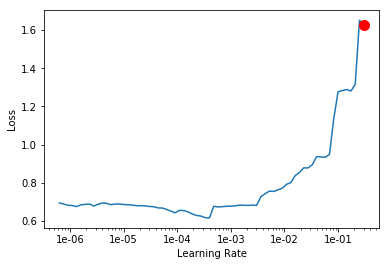

In [15]:
learner.lr_find()
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.368709,0.363281,0.861111,02:48
1,0.296050,0.334891,0.902778,02:48


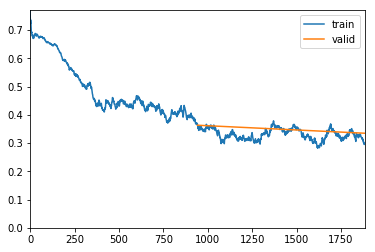

In [16]:
# learner.fit_one_cycle(2, max_lr=1e-4,moms=(0.8,0.7))
learner.fit_one_cycle(2, slice(1e-4))
learner.save('first')

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.58E-07


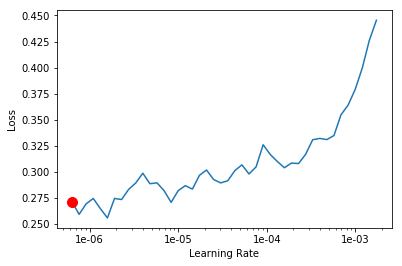

In [17]:
learner.unfreeze()
learner.lr_find()
learner.recorder.plot(suggestion=True)

epoch,train_loss,valid_loss,accuracy,time
0,0.321757,0.328437,0.875000,02:48


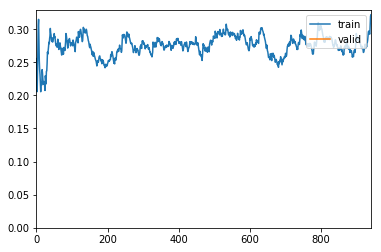

In [18]:
lr = 1e-6
# learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))
learner.fit_one_cycle(1, slice(1e-6))

In [19]:
def get_preds_as_nparray(ds_type) -> np.ndarray:
    """
    the get_preds method does not yield the elements in order by default
    we borrow the code from the RNNLearner to resort the elements into their correct order
    """
    preds = learner.get_preds(ds_type)[0].detach().cpu().numpy()
    sampler = [i for i in databunch.dl(ds_type).sampler]
    reverse_sampler = np.argsort(sampler)
    return preds[reverse_sampler, :]

In [20]:
# validation results 
from sklearn.metrics import classification_report, f1_score , recall_score, precision_score

preds, val_labels = learner.get_preds(DatasetType.Valid)
val_preds = []
for i in preds:
    val_preds.append(np.argmax(i))
print(classification_report(val_preds,val_labels))

              precision    recall  f1-score   support

           0       0.93      0.88      0.91        49
           1       0.77      0.87      0.82        23

    accuracy                           0.88        72
   macro avg       0.85      0.87      0.86        72
weighted avg       0.88      0.88      0.88        72



In [21]:
ori = pd.read_csv('../input/results/submission.csv')
sub = pd.read_csv("/kaggle/input/nlp-getting-started/sample_submission.csv")

In [22]:
test_set = SSTDataset(test, test_indicator=True)
test_loader = torch.utils.data.DataLoader(test_set,  batch_size = config.bs, shuffle=False, drop_last=False)

In [23]:
# test results 
test_preds = np.array([])

import tqdm
bert_model = learner.model
bert_model.eval()

for it, (seq, attn_masks) in enumerate(test_loader):
    seq = seq.cuda()
    attn_masks = attn_masks.cuda()
    batch_logits = bert_model(seq, attn_masks).detach().cpu().numpy()
    batch_preds = np.argmax(batch_logits, axis=1)
    test_preds = np.concatenate([test_preds,batch_preds])

In [24]:
print(classification_report(test_preds,ori['target'],  digits = 4))

              precision    recall  f1-score   support

         0.0     0.8898    0.8410    0.8648      1969
         1.0     0.7767    0.8416    0.8079      1294

    accuracy                         0.8413      3263
   macro avg     0.8333    0.8413    0.8363      3263
weighted avg     0.8450    0.8413    0.8422      3263



In [25]:
sub.shape,len(test_preds)

((3263, 2), 3263)

In [26]:
sub['target'] = test_preds
sub['target'] = sub['target'].astype(int)
sub.to_csv('submission.csv', index=False)
sub.head(3)

,id,target
0,0,1
1,2,1
2,3,1
